<h1><center>Lab 2</center></h1>

<h4 style='font-family:verdana;'>The task requires implementing three algorithms: Huffman, LZW, LZ77 and one additional algorithm DEFLATE.</h4>
<p style='font-family:verdana'>
Additionally, we need to test our algorithms on a different amount of data and compare it's runtime. Also, estimate the compression ratio in percentage.
</p>

## Huffman's algorithm

<p style='font-family:verdana;'>
Lossless data compression algorithm. The code length is related to how frequently characters are used. Most frequent characters have the smallest codes and longer codes for least frequent characters.
</p>

In [77]:
import heapq
from pprint import pprint

DICTIONARY = dict[str, str]

class Huffman:
    """ Huffman algorithm """
    def encode(self, message: str) -> str:
        """encode by Huffman algorithm

        Args:
            message (str): message to encode   

        Returns:
            str: encoded message

        >>> huffman = Huffman()
        >>> huffman.encode('Lorem ipsum dolor sit.')
        '1111110100011101011100010110110011100101110011100101110101010001000010101100011110'
        """
        dictionary = self.get_dictionary(message)

        # get code for every character in message
        result = "".join([dictionary[element] for element in message])
        return result

    def get_dictionary(self, message: str) -> DICTIONARY:
        """dictionary of Huffman code

        Args:
            message (str): message to encode

        Returns:
            DICTIONARY: dictionary that was used to encode

        >>> huffman = Huffman()
        >>> huffman.get_dictionary('abacabacacabaca')
        {'b': '00', 'a': '1', 'c': '01'}
        """
        unique = set(message)
        probabilities = []

        for letter in unique:
            heapq.heappush(probabilities, [message.count(letter), 0, letter])

        # get encoding scheme and convert it to dictionary
        scheme = self.__create_scheme(probabilities)
        dictionary = {element[2]: element[1] for element in scheme}

        return dictionary

    def __create_scheme(self, probabilities):
        """
        encoding scheme
        It has to be a tree, but I decided to work with lists
        """
        # if only 1 element in string
        if len(probabilities) <= 1:
            return [[probabilities[0][0], str(probabilities[0][1]), probabilities[0][2]]]

        # if we divided it to 2 symbols
        if len(probabilities) == 2:
            first, second = probabilities
            first[1] = '0'
            second[1] = '1'
            return [first, second]

        # three and more letters
        # get 2 elements with lowest probabilities and sum them
        first_lowest = heapq.heappop(probabilities)
        second_lowest = heapq.heappop(probabilities)

        lowest_sum = first_lowest[0] + second_lowest[0]

        heapq.heappush(probabilities, [lowest_sum, 0])

        # recursively add 2 elements with lowest probabilities
        probabilities = self.__create_scheme(probabilities)

        # code for this 2-elements
        code = None
        for idx, element in enumerate(probabilities):
            # find 2-elements and delete it from heapq
            # if len(element) == 3 => that's not 2-elements, it's a character
            # with the same probability
            if element[0] == lowest_sum and len(element) < 3:
                code = element[1]
                del probabilities[idx]
                break

        # add 0 and 1 to left and right element
        first_lowest[1] = code + '0'
        second_lowest[1] = code + '1'

        heapq.heappush(probabilities, first_lowest)
        heapq.heappush(probabilities, second_lowest)

        return probabilities

    def decode(self, message: str, dictionary: DICTIONARY) -> str:
        """Decode message by Huffman algorithm

        Args:
            message (str): encoded message
            dictionary (DICTIONARY): dictionary that was created while encoding

        Returns:
            str: decoded message

        >>> huffman = Huffman()
        >>> huffman.decode('1001011001011011001011', {'b': '00', 'a': '1', 'c': '01'})
        'abacabacacabaca'
        """
        reverse_dictionary = {value: key for key, value in dictionary.items()}

        result = ""

        idx = 0

        # find a code that's in dictionary and decode it
        while idx < len(message):
            for length in range(1, len(message) + 1):
                code = message[idx : idx + length]

                if code in reverse_dictionary:
                    result += reverse_dictionary[code]
                    idx += length
                    break

        return result

    def assertion(self, message: str, verbose = False):
        """Test a string. Prints encoded message, dictionary and 
        checks weather message == decode(encode(message)).
        In case it's not — returns error.

        Args:
            message (str): test message
            verbose (bool, optional): Show full info. Defaults to False.

        >>> huffman = Huffman()
        >>> huffman.assertion('abaca')
        """
        encoded = self.encode(message)
        dictionary = self.get_dictionary(message)

        if verbose:
            print(f"Encoded: {encoded}")
            pprint(dictionary)

        assert message == self.decode(encoded, dictionary)

## LZW algorithm

<p style='font-family:verdana;'>
Universal lossless data compression algorithm. The LZW algorithm works by creating a dictionary of frequently occurring phrases in the input data. As the algorithm scans through the input data, it adds new phrases to the dictionary and replaces repeated occurrences of those phrases with a shorter code that represents the phrase in the dictionary. The codes are then output as a compressed stream of data.
</p>

In [78]:
class LZW:
    """ LZW class """
    def compress(self, message: str) -> list[int]:
        """Compress message

        Args:
            message (str): message to compress

        Returns:
            list[int]: compressed message (list of ints)

        >>> lzw = LZW()
        >>> lzw.compress('abacabadabacacacd')
        [0, 1, 0, 2, 4, 0, 3, 8, 7, 12, 3]
        """
        # get only unique strings of length 1
        dictionary = self.get_initial_dictionary(message)
        code = []

        idx = 0
        message_length = len(message)

        # go through every letter
        while idx < message_length:
            # get str of every length
            for length in range(1, message_length + 1):
                current = message[idx : idx + length]

                # if this substr is in dictionary skip this
                if current in dictionary and idx + length <= message_length:
                    continue

                # get previous substr (without last letter)
                length -= 1
                prev = message[idx : idx + length]

                code.append(dictionary.index(prev))
                dictionary.append(current)

                idx += length
                break

        return code

    @staticmethod
    def get_initial_dictionary(message: str) -> list[str]:
        """get only unique strings of length 1. 

        Args:
            message (str): initial message

        Returns:
            list[str]: dictionary

        >>> lzw = LZW()
        >>> lzw.get_initial_dictionary('abacabadabacacacd')
        ['a', 'b', 'c', 'd']
        """
        return list(sorted(set(message)))

    @staticmethod
    def decompress(code: str, dictionary: list[str]) -> str:
        """decompress compressed message

        Args:
            code (str): code which represents message
            dictionary (list[str]): initial dictionary of message

        Returns:
            str: decoded message

        >>> lzw = LZW()
        >>> lzw.decompress([0, 1, 0, 2, 4, 0, 3, 8, 7, 12, 3], ['a', 'b', 'c', 'd'])
        'abacabadabacacacd'
        """
        message = ""

        for idx, element in enumerate(code):
            decoded = dictionary[element]
            message += decoded

            # if not out of range
            if idx + 1 >= len(code):
                break

            # if next code is in dictionary
            if code[idx + 1] < len(dictionary):
                # add to dict this decoded element + first letter of next
                dictionary.append(decoded + dictionary[code[idx + 1]][0])
            else:
                # add only this decoded and first letter of current
                dictionary.append(decoded + decoded[0])

        return message

    def assertion(self, message: str, verbose = False):
        """Checks weather message == decompress(compress(message))

        Args:
            message (str): original message
            verbose (bool, optional): full info. Defaults to True.

        >>> lzw = LZW()
        >>> lzw.assertion('abacabadabacacacd')
        """
        compressed = self.compress(message)
        dictionary = self.get_initial_dictionary(message)

        if verbose:
            print(f"Compressed: {compressed}")
            print(f"Minimal dictionary: {dictionary}")

        assert message == self.decompress(compressed, dictionary)

## LZ77 algorithm

<p style='font-family:verdana;'>
The LZ77 algorithm works by searching for repeated patterns in the input data, called "matches." It uses a sliding window technique to search for matches, which starts at the beginning of the input data and slides over the data one character at a time. Each time the window moves, the algorithm searches for the longest matching string of characters that occurs earlier in the input data (buffer). If a match is found, the algorithm outputs a tuple of values: the offset, the length of the match and the next character.
</p>

In [79]:
from math import ceil
from os import path


class LZ77:
    """
    Lempel-Ziv algorithm.
    """
    @staticmethod
    def compress(message: str, buffer_size: int = 5) -> list[tuple]:
        """
        Compressing message with lz77 algorithm.

        Args:
            message (str): message to compress
            buffer_size (int): size of the buffer (default 5)

        Returns:
            list[tuple[int, int, str]]: compressed message
            (list of tuples with three elements: <offset, length, next>)

        >>> lz77 = LZ77()
        >>> lz77.compress('abacabacabadaca')
        [(0, 0, 'a'), (0, 0, 'b'), (2, 1, 'c'), (4, 7, 'd'), (2, 1, 'c'), (2, 1, None)]
        """
        if not all([isinstance(message, str), isinstance(buffer_size, int)]):
            return None

        result = []
        buffer = ''
        ind = 0

        while ind < len(message):
            start = ind
            copy_buff = buffer

            while message[start : ind + 1] in buffer and ind != len(message):
                ind += 1

                if message[start : ind + 1] not in buffer:
                    buffer *= 2

            ext_buff = buffer
            buffer = copy_buff
            i = ind + 1

            # finding offset
            substr = message[start : i]
            copy_substr = substr[:-1]

            while substr not in buffer:
                i -= 1
                substr = message[start : i]

            offset = 0 if len(substr) == 0 else buffer.rfind(substr)

            if len(substr) != 0:
                offset = len(buffer) - offset

            if offset != 0:
                while copy_substr != ext_buff[
                    len(buffer) - offset : len(buffer) - offset + len(copy_substr)]:
                    offset -= 1

            # getting the next symbol
            if len(message[start : ind + 1]) == ind - start:
                next_sym = None
            else:
                next_sym = message[start : ind + 1][-1]

            # forming tuples
            result.append((offset, len(message[start : ind]), next_sym))

            # updating buffer
            buffer += message[start : ind + 1]
            buffer = buffer[-buffer_size:] if len(buffer) > 5 else buffer
            ind += 1

        return result


    @staticmethod
    def decompress(encoded_message: list[tuple], buffer_size: int = 5) -> str:
        """
        Decompressing encoded message.

        Args:
            encoded_message (list[tuple]): encoded message

        Returns:
            str: decoded string

        >>> lz77 = LZ77()
        >>> lz77.decompress([(0, 0, 'a'), (0, 0, 'b'), (2, 1, 'c'), \
(4, 7, 'd'), (2, 1, 'c'), (2, 1, None)])
        'abacabacabadaca'
        """
        if not isinstance(encoded_message, list) or not isinstance(buffer_size, int):
            return None

        if not all(len(i) == 3 and isinstance(i, tuple) for i in encoded_message):
            return None

        if not all(isinstance(i, int) and isinstance(j, int) and
                   (z is None or isinstance(z, str)) for i, j, z in encoded_message):
            return None

        result = ''

        for offset, length, next_sym in encoded_message:
            buffer = result[-buffer_size:]
            start = len(buffer) - offset
            stop = start + length
            next_sym = '' if next_sym is None else next_sym

            if offset < length:
                result += (buffer * ceil(length / offset))[start : stop] + next_sym
            else:
                result += buffer[start : stop] + next_sym

        return result


    @classmethod
    def read_compress_file(cls, file_path: str):
        """
        Read content from file.

        Args:
            path (str): path to the existing file

        Returns:
            list[tuple[int, int, str]]: compressed message
            (list of tuples with three elements: <offset, lenght, next>)
        """
        if not isinstance(file_path, str) or not path.exists(file_path):
            return None

        if not path.isfile(file_path):
            print(f"There is not such file {file_path}")
            return None

        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()

        name = file_path.split('/')[-1].split('.')[0] + '_encoded'

        with open(f'{name}.txt', 'w', encoding='utf-8') as fil:
            result = []

            for offset, length, next_character in cls.compress(content):
                result.append(f"{offset}{length}{next_character or ' '}")

            fil.write("".join(result))

        return None

    @classmethod
    def assertion(cls, message: str) -> bool:
        """
        Assert an initial message is equal to the encoded an decoded one.

        Args:
            message (str): message to check the correctness

        Returns:
            bool: True if they are equal, False otherwise.

        >>> lz77 = LZ77()
        >>> lz77.assertion('abacabacabadaca')
        >>> lz77.assertion('1100101110011100101110101010001000010101100011110')
        """
        if not isinstance(message, str):
            return None

        encoded = cls.compress(message)

        assert message == cls.decompress(encoded)

## DEFLATE

<p style='font-family:verdana;'>
Deflate is a lossless compression algorithm that combines two other compression algorithms: LZ77 and Huffman coding. The Deflate algorithm first uses the LZ77 algorithm to find repeated patterns in the input data, which are represented as "match" pairs consisting of a length value and a distance value. The match pairs are then encoded using Huffman coding, which assigns shorter codes to more frequently occurring pairs and longer codes to less frequently occurring pairs.
</p>

In [80]:
from os import path

In [81]:
class Deflate:
    """
    DEFLATE algorithm.
    """

    def deflate_encode(self, message: str, buffer_size: int = 5, to_file = False,
                       return_dict = False):
        """
        DEFLATE algorithm.

        Args:
            message (str): message to encode
            buffer_size (int): buffer size for lz77 algorithm

        Returns:
            str: encoded str

        >>> defl = Deflate()
        >>> defl.deflate_encode('Hello')
        '11010011010111011000000111'
        """
        lz77 = LZ77()
        huffman = Huffman()
        encoded_lz77 = "".join([str(offset) + str(length) + symb if symb is not None else
                                str(offset) + str(length) + ' '
                                for offset, length, symb in lz77.compress(message, buffer_size)])
        encoded_huffman = huffman.encode(encoded_lz77)
        dictionary = huffman.get_dictionary(encoded_lz77)

        if to_file:
            with open('deflate.txt', 'w', encoding='utf-8') as file:
                file.write(encoded_huffman)
            return None
        if return_dict:
            return encoded_huffman, dictionary
        return encoded_huffman


    def deflate_decode(self, encoded_str: str, dictionary: DICTIONARY, buffer_size: int = 5):
        """
        Decoding deflate algorithms.

        Args:
            encoded_str (str): encode message
            buffer_size (int): buffer size for lz77 algorithm

        Returns:
            str: decoded str

        >>> defl = Deflate()
        >>> b, d = defl.deflate_encode('Hello', return_dict = True)
        >>> defl.deflate_decode(b, d)
        'Hello'
        """
        if not isinstance(encoded_str, str) or not isinstance(buffer_size, int):
            return None
        lz77 = LZ77()
        huffman = Huffman()
        decoded_huffman = huffman.decode(encoded_str, dictionary)
        list_of_tuples = [(int(decoded_huffman[i]), int(decoded_huffman[i + 1]),
                           decoded_huffman[i + 2])
                           for i in range(0, len(decoded_huffman), 3)]
        return lz77.decompress(list_of_tuples, buffer_size)


    @staticmethod
    def read_compress_file(file_path: str):
        """
        Read content from file.

        Args:
            path (str): path to the existing file

        Returns:
            list[tuple[int, int, str]]: compressed message
            (list of tuples with three elements: <offset, lenght, next>)
        """
        if not isinstance(file_path, str) or not path.exists(file_path):
            return None
        if not path.isfile(file_path):
            return None

        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()

        name = file_path.split('/')[-1].split('.')[0] + '_encoded'
        with open(f'{name}.txt', 'w', encoding='utf-8') as file:
            obj = Deflate()
            file.write(obj.deflate_encode(content))
        return None

<h2><center>Testing algorithms</center><h2>

In [82]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import sys
import os

In [83]:
def time_taken(func, path: str, iteration: int = 1000):
    """
    Timer for analysing the execution time of algorithms.

    Parameters
    ----------
    func : function
        function for finding shortest paths
    file : int
        path to file to read the content
    iteration : int
        number of iterations

    Returns
    -------
    float
        execution time of the algorithm
    """
    exec_time = 0

    with open(path, 'r', encoding='utf-8') as file:
        content = file.read()

    for _ in tqdm(range(iteration)):
        start = time.time()
        func(message=content)
        end = time.time()

        exec_time += end - start

    return exec_time / iteration

In [88]:
def compare_sizes(func, path, _):
    with open(path, 'r', encoding='utf-8') as file:
        content = file.read()

    content_size = len(content)
    encoded = func(content)    

    return len(encoded) * 100 / content_size

In [85]:
def compare(functions, comparison, iterations: int = 10):
    """
    Compare four algorithms for different size of inputs.
    """
    files = ['sample1000.txt', 'sample5000.txt', 'sample10000.txt', 'sample50000.txt']

    plt.figure(figsize=(10,6))
    plt.title("Comparing algorithms")

    sizes = []

    for filename in files:
        with open(filename, 'r') as file:
            text = file.read()
            sizes.append(len(text))

    for fun in functions:
        algo = [comparison(fun, file, iterations) for file in files]
        plt.plot(sizes, algo)

    plt.legend(['Huffman', 'LZW', 'LZ77', "Deflate"], loc='upper left', shadow=True)
    plt.xlabel('size (in Bytes)')
    plt.ylabel('time')
    return plt.show()

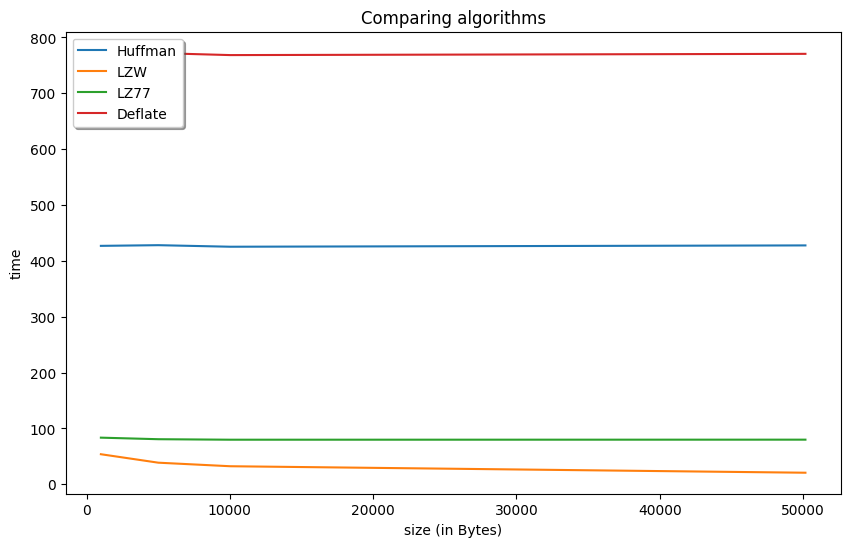

In [91]:
# compare([Huffman().encode, LZW().compress, LZ77().compress, Deflate().deflate_encode], time_taken)
compare([Huffman().encode, LZW().compress, LZ77().compress, Deflate().deflate_encode], compare_sizes)


<div style='border: 1px solid red;
  border-radius: 12px;
  margin: 0;'>
  <p style='margin: 12px; font-family:verdana;'>
  Comparison
  </p>
</div>

### Contributors:
* Victor Muryn — Huffman and LZW
- Ksenia Kretsula — LZ77 and Deflate
